In [14]:
import os
import sys
import random
import warnings
import cv2
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import AveragePooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Set some parameters
IMG_WIDTH = 152
IMG_HEIGHT = 60
IMG_CHANNELS = 3

TRAIN_PATH='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/x_train_new/'
TEST_PATH ='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/x_test_new/'
MASK_TRAIN='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/y_train_new/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [15]:
!pip install tensorflow==1.14.0

In [16]:
!pip install keras==2.3.1

In [6]:
import keras
keras.__version__

Using TensorFlow backend.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-pa

'2.3.1'

In [7]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [17]:
# #한글이름 사진 로드
from PIL import Image

#gray로 불러와야 threshold  함수 사용가능
def hangulFilePathImageRead2 (filePath ) :  
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

In [18]:
train_path=os.walk(TRAIN_PATH) #raw
train_ids= next(train_path)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]

In [19]:
test_ids.sort()
train_ids.sort()
mask_ids.sort()

In [20]:
len(train_ids)

1880

In [21]:
len(test_ids)

600

In [22]:
len(mask_ids)

1880

In [23]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    train_= hangulFilePathImageRead2(MASK_TRAIN+id_)
    mask_=cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,15, 11) 
    mask_= np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    #mask = np.maximum(mask, mask_)
    Y_train[n] = mask_
    

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH+id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1880/1880 [00:05<00:00, 372.31it/s]

Getting and resizing test images ... 



100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 244.45it/s]

Done!


In [24]:
print(Y_train.shape)
print(X_train.shape)
print(X_test.shape)
#print(mask_.shape)
#print(test_.shape)

(1880, 60, 152, 1)
(1880, 60, 152, 3)
(600, 60, 152, 3)


1356


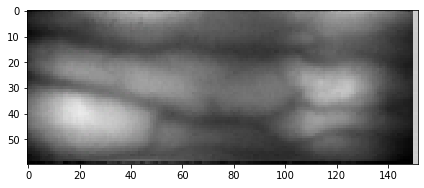

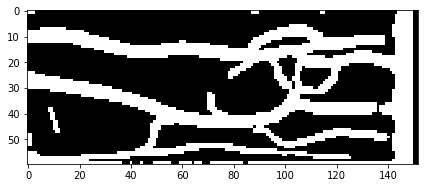

In [25]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
print(ix)
imshow(X_train[0])
plt.show()
imshow(np.squeeze(Y_train[0]))
plt.show()

In [13]:
# Define IoU metric
# #tf.dtypes.cast(x, tf.int32)
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred= tf.dtypes.cast(y_pred, tf.int32)
#         y_pred_ = y_pred > t
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

# Define IoU metric_new
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
# densenet 모델을 위한 함수
def _bn_relu_conv(x, growth_rate, dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=-1, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, (3, 3), kernel_initializer='he_normal', padding="same", use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

def transition(x, nb_filter, dropout_rate=None, weight_decay=1E-4, pooling=True):
    x = BatchNormalization(axis=-1, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (1, 1), kernel_initializer='he_normal', padding="same", use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    if pooling:
        x = AveragePooling2D(pool_size=(2, 2))(x)
    return x

def denseblock(x, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1E-4):
    for i in range(nb_layers):
        merge_tensor = _bn_relu_conv(x, growth_rate, dropout_rate, weight_decay)
        x = Concatenate(axis=-1)([merge_tensor, x])
        nb_filter += growth_rate
    return x, nb_filter

In [15]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [16]:
from tensorflow.python.keras.metrics import Metric
from keras import metrics

nb_filter = 6
growth_rate = 12
dropout_rate = 0.5
weight_decay = 1e-4

# Build U-Net model
inputs = Input((60, 152, 3))
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization(axis=3, momentum=0.99)(c1) # Tensorflow uses filter format [filter_height, filter_width, in_channels, out_channels], hence axis = 3
c1 = ELU()(c1)
dense1, nb_filter = denseblock(c1, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense1 = transition(dense1, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
p1 = AveragePooling2D(pool_size=(2, 2))(dense1)
print("p1",p1)
c1_filter = nb_filter

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization(axis=3, momentum=0.99)(c2) # Tensorflow uses filter format [filter_height, filter_width, in_channels, out_channels], hence axis = 3
c2 = ELU()(c2)
dense2, nb_filter = denseblock(c2, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense2 = transition(dense2, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense2, nb_filter = denseblock(dense2, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense2 = transition(dense2, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("c2",dense2)
c2_filter = nb_filter

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (dense2)
dense3, nb_filter = denseblock(c3, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense3 = transition(dense3, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense3, nb_filter = denseblock(dense3, 6, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense3 = transition(dense3, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
p3 = AveragePooling2D(pool_size=(2, 2))(dense3)
print("p3",p3)
c3_filter = nb_filter

dense4, nb_filter = denseblock(p3, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense4, nb_filter = denseblock(dense4, 6, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense4, _ = denseblock(dense4, 6, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense4, _ = denseblock(dense4, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("mid", dense4)

u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (dense4)
u5 = concatenate([u5, dense3])
dense5, _ = denseblock(u5, 6, c3_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense5 = transition(dense5, c3_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense5, _ = denseblock(dense5, 3, c3_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense5 = transition(dense5, c3_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("u5",dense5)

c6 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (dense5)
dense6, _ = denseblock(c6, 3, c2_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense6 = transition(dense6, c2_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense6, _ = denseblock(dense6, 3, c2_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense6 = transition(dense6, c2_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("c6",dense6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (dense6)
u7 = concatenate([u7, dense1])
dense7, _ = denseblock(u7, 3, c1_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense7 = transition(dense7, c1_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("u7",dense7)

outputs = Conv2D(64, (1, 1), activation='sigmoid') (dense7)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (outputs)
print("outputs",outputs)
#mIOU = tf.keras.metrics.MeanIoU(num_classes=20)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("lambda_2/truediv:0", shape=(?, 60, 152, 3), dtype=float32)

p1 Tensor("average_pooling2d_1/AvgPool:0", shape=(?, 30, 76, 42), dtype=float32)
c2 Tensor("dropout_12/cond/Merge:0", shape=(?, 30, 76, 114), dtype=float32)
p3 Tensor("average_pooling2d_2/AvgPool:0", shape=(?, 15, 38, 222), dtype=float32)
mid Tensor("dropout_45/cond/Merge:0", shape=(?, 15, 38, 330), dtype=float32)
u5 Tensor("dropout_56/cond/Merge:0", shape=(?, 30, 76, 222), dtype=float32)
c6 Tensor("dropout_64/cond/Merge:0", shape=(?, 30, 76, 114), dtype=float32)
u7 Tensor("dropout_68/cond/Merge:0", shape=(?, 60, 152, 42), dtype=float32)
outputs Tensor("conv2d_74/Sigmoid:0", shape=(?, 60, 152, 1), dtype=float32)
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
_________________________________________________________________________

In [17]:
# Fit model
earlystopper = EarlyStopping(patience=7, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=45, callbacks=[earlystopper, checkpointer])


Train on 1692 samples, validate on 188 samples
Epoch 1/45
1692/1692 [==============================] - 3173s 2s/step - loss: 2.3486 - mean_iou: 0.0493 - val_loss: 2.5200 - val_mean_iou: 0.0403

Epoch 00001: val_loss improved from inf to 2.52003, saving model to model-dsbowl2018-1.h5
Epoch 2/45
1692/1692 [==============================] - 3141s 2s/step - loss: 1.8309 - mean_iou: 0.0603 - val_loss: 2.3072 - val_mean_iou: 0.0735

Epoch 00002: val_loss improved from 2.52003 to 2.30722, saving model to model-dsbowl2018-1.h5
Epoch 3/45
1692/1692 [==============================] - 3140s 2s/step - loss: 1.6018 - mean_iou: 0.0807 - val_loss: 1.9695 - val_mean_iou: 0.0863

Epoch 00003: val_loss improved from 2.30722 to 1.96951, saving model to model-dsbowl2018-1.h5
Epoch 4/45
1692/1692 [==============================] - 3141s 2s/step - loss: 1.4361 - mean_iou: 0.0899 - val_loss: 1.6194 - val_mean_iou: 0.0932

Epoch 00004: val_loss improved from 1.96951 to 1.61935, saving model to model-dsbowl20

In [22]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.3).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)
preds_test_t = (preds_test > 0.3).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

600/600 [==============================] - 310s 516ms/step


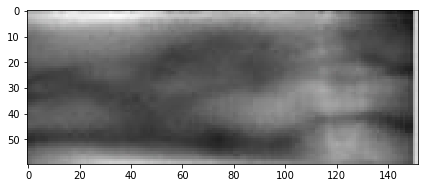

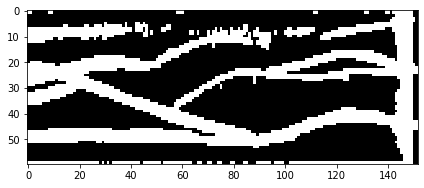

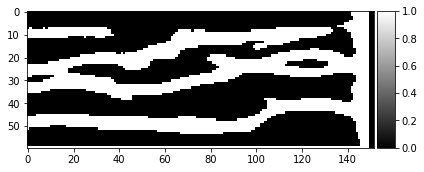

In [25]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

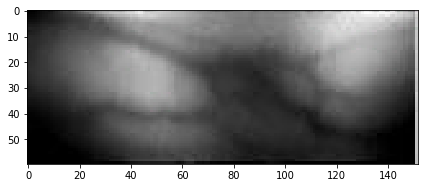

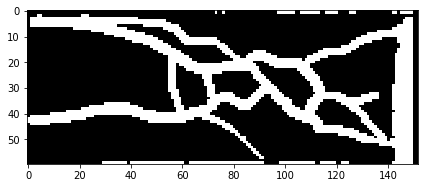

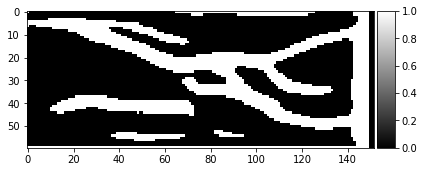

In [27]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]),cmap='gray')
plt.show()

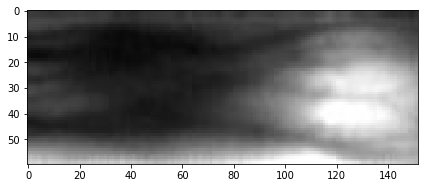

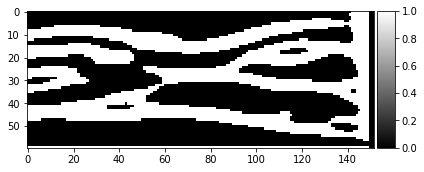

In [28]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap='gray')
plt.show()

In [29]:
from skimage.io import imsave

x_test_name=[]
os.listdir(TEST_PATH).sort()
for f in os.listdir(TEST_PATH):  
    if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
#         print(f.split('.')[0])
        x_test_name.append(f.split('.')[0])

In [31]:
img_result=np.squeeze(preds_test_t)
img_result=img_result[:,:]*255
print(img_result[0])

[[  0   0   0 ... 255   0   0]
 [  0   0   0 ... 255   0   0]
 [  0   0   0 ... 255   0   0]
 ...
 [  0   0   0 ... 255   0   0]
 [  0   0   0 ... 255   0   0]
 [255 255 255 ... 255   0   0]]


In [33]:
for i in range(len(img_result)):
    imsave(r'./x_test_result/'+x_test_name[i]+'.jpg',img_result[i])  #결과저장

In [112]:
img_result[1].shape

(60, 152)

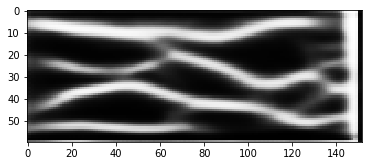

In [34]:
plt.imshow(np.squeeze(preds_test_upsampled[0]),cmap='gray')
plt.show()

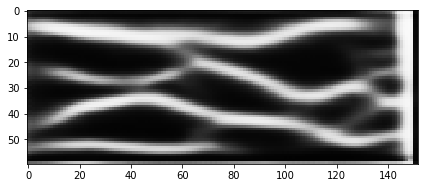

In [409]:
imshow(preds_test_upsampled[0])

In [411]:
preds_test_upsampled[0].shape

(60, 152)

In [35]:
for i in range(len(preds_test_upsampled)):
    imsave(r'./x_test_result_upsampled/'+x_test_name[i]+'.jpg',preds_test_upsampled[i])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [36]:
#혹시모르니까용
img_result2=np.squeeze(preds_test_upsampled)
img_result2=img_result2[:,:]*255
print(img_result2[0])

[[ 45.41545    41.43265    39.04239   ... 225.98682    11.968066
   12.232152 ]
 [ 45.542572   38.86135    31.221571  ... 240.87218    11.484435
   11.925067 ]
 [ 33.051243   29.490696   23.323042  ... 227.7981      5.749487
    5.1931357]
 ...
 [ 15.166726   11.748506    7.683104  ... 147.65875     5.517076
    4.7607875]
 [  7.31251     5.6463375   4.7610836 ... 177.6155      3.7643592
    3.3197906]
 [ 94.81361   100.01098   102.31425   ... 226.78566    12.620696
   11.439993 ]]


In [37]:
for i in range(len(img_result2)):
    imsave(r'./x_test_result_upsampled2/'+x_test_name[i]+'.jpg',img_result2[i])

Lossy conversion from float32 to uint8. Range [2.4519248008728027, 249.42904663085938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.1261074542999268, 250.01573181152344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.3562004566192627, 249.6163330078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.854771614074707, 250.3124542236328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9752099514007568, 249.80050659179688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [4.200552940368652, 250.16119384765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.112861394882202, 249.24319458007812].

Lossy conversion from float32 to uint8. Range [1.9892237186431885, 246.5924835205078]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.813391923904419, 246.59852600097656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.141261100769043, 249.24476623535156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.988197684288025, 246.46559143066406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9673292636871338, 247.22772216796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.7033040523529053, 248.08570861816406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.886568307876587, 249.58021545410156].

Lossy conversion from float32 to uint8. Range [3.696760892868042, 249.16323852539062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.0550589561462402, 249.5226287841797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.538727283477783, 246.69224548339844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.9373488426208496, 245.47715759277344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.295396089553833, 246.6011962890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.386355400085449, 246.76846313476562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.5493364334106445, 246.71218872070312]. 

Lossy conversion from float32 to uint8. Range [4.309432506561279, 248.57305908203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.8692033290863037, 247.17640686035156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.180148124694824, 249.86648559570312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.802167296409607, 246.86471557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.972238540649414, 246.8263702392578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.5774929523468018, 247.9847869873047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9150668382644653, 248.48593139648438]. 

Lossy conversion from float32 to uint8. Range [2.1127171516418457, 249.04629516601562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9518564939498901, 247.88449096679688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.999558925628662, 246.13465881347656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9383596181869507, 243.63499450683594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9528292417526245, 249.58367919921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.7309515476226807, 249.8927459716797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9657028913497925, 250.0082092285156

Lossy conversion from float32 to uint8. Range [2.0197055339813232, 247.51805114746094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.920644998550415, 248.40936279296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.7905094623565674, 248.8710174560547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.4380176067352295, 250.43075561523438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.7912846803665161, 247.31407165527344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9003312587738037, 248.58319091796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.777962565422058, 248.64950561523438

Lossy conversion from float32 to uint8. Range [1.885466456413269, 249.55824279785156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.816689968109131, 249.2927703857422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.8675769567489624, 249.8287811279297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.2934961318969727, 249.12411499023438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.3815600872039795, 248.3560791015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9101574420928955, 249.1192169189453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.0022037029266357, 250.04116821289062]. 

Lossy conversion from float32 to uint8. Range [3.9413764476776123, 247.29832458496094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.8164469003677368, 246.96786499023438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.0466158390045166, 247.9001007080078]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.610482692718506, 248.85394287109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.7332618236541748, 248.83834838867188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.783479928970337, 247.98147583007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.6965025663375854, 249.4365234375]. C

Lossy conversion from float32 to uint8. Range [3.6160531044006348, 246.9842529296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.8937803506851196, 249.08155822753906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.5037083625793457, 247.15756225585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.53525447845459, 246.98350524902344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.787021279335022, 247.7331085205078]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.7722021341323853, 247.83270263671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.7797105312347412, 247.09999084472656].

Lossy conversion from float32 to uint8. Range [1.90192711353302, 249.2267303466797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.870274782180786, 248.7317352294922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9476995468139648, 248.39602661132812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.072469711303711, 247.95034790039062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9505797624588013, 248.37159729003906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.983098268508911, 247.71633911132812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.4333817958831787, 247.85665893554688]. C

Lossy conversion from float32 to uint8. Range [2.5479607582092285, 246.74583435058594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9357681274414062, 247.78372192382812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.8160440921783447, 245.7184600830078]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.9342708587646484, 245.99232482910156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [4.482209205627441, 246.9486541748047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.268721342086792, 248.24713134765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.6479713916778564, 248.92478942871094]

Lossy conversion from float32 to uint8. Range [3.440593719482422, 246.16973876953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9077104330062866, 249.70590209960938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [3.975179433822632, 248.2081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.95124089717865, 247.3444061279297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.061131000518799, 248.24855041503906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.8527958393096924, 248.4950714111328]. Convert image to uint8 prior to saving to suppress this warning.


# -----------------------------------------

#### 여기는 지민이가 세선화해서 다시 저장

In [372]:
#결과 가져오기
from PIL import Image
import glob
image_list = []
for filename in glob.glob('x_test_result/*.jpg'):   
    im=Image.open(filename)
    image_list.append(im)

In [373]:
b=len(image_list2)

In [374]:
print(b)

600


In [380]:
#원본 가져오기
from PIL import Image
import glob
import numpy as np
from skimage.io import imsave
import os
image_list2 = []
name=[]

x_test_name=[]
os.listdir(TEST_PATH).sort()
for f in os.listdir(TEST_PATH):  
    if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
        x_test_name.append(f.split('.')[0])   #이미지 이름
    
    
for filename in glob.glob('x_test_new/*.jpg'): 
    im=Image.open(filename)
    image_list2.append(im)
    
for i in range(500,501):  
    image_array2 = np.asarray(image_list2[i]) #원본을 array로
    image_array2 = cv2.cvtColor(image_array2, cv2.COLOR_BGR2GRAY)  #image_array2가 비트사이즈가 24이므로 gray스케일로 바꿔줌.

In [381]:
def join(imagem,image_array2):#세선화, 원본
    image_array3=image_array2
    for i in range(0,60):
        for j in range(0,152):
            if(imagem[i][j]==True):  #정맥이면
                image_array3[i][j]=0
    return image_array3

[SEG]현교환_8_1


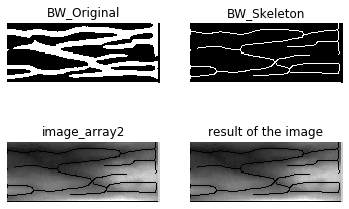

In [382]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import filters
import cv2
from skimage.io import imsave
"load image data"
path='C:/Users/308_1/Desktop/Jimin/x_test_result'

    
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0

        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned


# "Apply the algorithm on images"
for i in range(500,501):
    image_array = np.asarray(image_list[i])  #결과를 array로 
    Img_Original = cv2.bitwise_not(image_array)  #흑백반전
    Otsu_Threshold = filters.threshold_otsu(Img_Original)   #Img_Original=np.array타입, (60.152)크기
    BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 
    BW_Skeleton = zhangSuen(BW_Original)  #세선화(bool타입)
    
    
    image_array2.setflags(write=1)
    result=join(BW_Skeleton,image_array2)  #합치기(세선화, 원본)
    imsave(r'./thinning/'+x_test_name[i]+'.jpg',result)
    print(x_test_name[i])
    
# BW_Skeleton = BW_Original
"Display the results"
fig, ax = plt.subplots(2, 2)
ax1, ax2,ax3,ax4 = ax.ravel()
ax1.imshow(BW_Original, cmap=plt.cm.gray)
ax1.set_title('BW_Original')
ax1.axis('off')
ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax2.set_title('BW_Skeleton')
ax2.axis('off')
ax3.imshow(image_array2, cmap=plt.cm.gray)
ax3.set_title('image_array2')
ax3.axis('off')
ax4.imshow(result, cmap=plt.cm.gray)
ax4.set_title('result of the image')
ax4.axis('off')
plt.show()

# -----------------------------------------